# Importations

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model,Model,Sequential

In [2]:
import tensorflow.keras as keras

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [6]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.activations import relu

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score,RocCurveDisplay,roc_curve, roc_auc_score

In [8]:
from aizynthfinder.chem import *
from aizynthfinder.utils import *
from aizynthfinder.training import *
from aizynthfinder.context import *

In [9]:
from aizynthfinder.utils.models import LocalKerasModel

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from keras.utils.vis_utils import plot_model

In [12]:
import SelectionGroup

In [13]:
import tqdm.notebook as tqdm

In [14]:
from tensorflow.keras.optimizers import Adam

# Modeles

### Récupération du modèle d'aizynth et création d'un nouveau modèle

In [15]:
def create_model(loss_function="binary_crossentropy", 
                   optimizer="adam", metrics=['accuracy']):
    '''
    Fonction permettant de récupérer le modèle d'AizynthFinder et de le modifier pour le Transfer Learning
    '''
    
    #On récupère le modèle d'AizynthFinder
    model = LocalKerasModel("C:/Users/Yassine/Desktop/aizynth/uspto_filter_model.hdf5")
    
    #On gèle les paramètres
    model.model.trainable = False
    
    #Le modèle d'AF prenant deux inputs il faut concatener les branches de l'ancien modèle
    concat = tf.keras.layers.Concatenate()([model.model.layers[3].output,model.model.layers[4].output])
    
    #On rajoute deux nouveaux layers, un layer dense et un layer de sortie. 
    hidden1 = tf.keras.layers.Dense(1024,name = "Dense_3",activation = 'relu')(concat)
    layer_out = tf.keras.layers.Dense(1,name = "dense_5", activation = "sigmoid")(hidden1)
    
    #On créé notre nouveau modèle
    new_model = Model(inputs = [model.model.layers[0].input,model.model.layers[2].input],outputs = layer_out)
    
    #On enregistre le modèle sous forme de jpg à des fins d'illustration du rapport 
    plot_model(new_model, to_file='filter_model_plot.png', show_shapes=True, show_layer_names=True)
    
    #On compile le nouveau modèle
    new_model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
    return new_model

### Setting Up Callbacks

#### Un callback est une fonction qui permet de modifier les hyperparamètres pendant  l'entraînement en fonction des mesures de précision à chaque epoch

In [18]:
#We set up a reducing learning rate call back
reduce_lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.8,
        patience=10,
        verbose=2,
        mode="auto",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0,)

In [17]:
#We set up an early stopping callback
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=25,
    verbose=2,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)


# Récupération des Datas 

In [19]:
fname_fp_false = "C:/Users/Yassine/Desktop/PSC/PSC_final/Data/False_reactions/Reactions_Fingerprint_False.csv"
fname_fp_true = "C:/Users/Yassine/Desktop/PSC/PSC_final/Data/True_reactions/Reactions_Fingerprint_True.csv"
fname_groups_false = "C:/Users/Yassine/Desktop/PSC/PSC_final/Data/False_reactions/False_reac_groups.csv"
fname_groups_true = "C:/Users/Yassine/Desktop/PSC/PSC_final/Data/True_reactions/True_reac_groups.csv"


In [20]:
data_fp_false = pd.read_csv(fname_fp_false)
data_fp_true = pd.read_csv(fname_fp_true)
data_groups_false = pd.read_csv(fname_groups_false)
data_groups_true = pd.read_csv(fname_groups_true)

In [21]:
#Les fonctions permettant de traiter les données pour qu'elles soient adaptées aux entrées des modèles

def fp_from_fp_db(fp_db):
    res = np.zeros(2048)
    list_idx = fp_db.split(" ")
    for el in list_idx[:-1]:
        lfp = el.split("-")
        n = len(lfp)
        if n == 1:
            res[int(lfp[0])] = 1
        elif n==2:
            res[int(lfp[0])] = int(lfp[-1])
        else:
            res[int(lfp[0])] = -int(lfp[-1])
    return res

def input_model_from_db(base_fp):
    prod_fp_db,rxn_fp_db = base_fp["Product_Fingerprint"],base_fp["Reaction_Fingerprint"]
    prod_fp,rxn_fp = np.empty(base_fp.shape[0],dtype = 'object'),np.empty(base_fp.shape[0],dtype = 'object')
    for i in range(base_fp.shape[0]):
        prod_fp[i]=fp_from_fp_db(prod_fp_db.iloc[i])
        rxn_fp[i]=fp_from_fp_db(rxn_fp_db.iloc[i])
    return prod_fp,rxn_fp

def get_fp_db_from_idx(base_idx,base_fp):
    return base_fp.iloc[base_idx["Indices"].values]

In [22]:
def get_data(data_fp_false,data_fp_true,grps):
    res = []
    fp_grps = SelectionGroup.select_grp(data_fp_false,data_fp_true,grps)
    for prod_fp_false,rxn_fp_false,prod_fp_true,rxn_fp_true in fp_grps:
        #n = min(prod_fp_false.shape[0],rxn_fp_false.shape[0],prod_fp_true.shape[0],rxn_fp_true.shape[0])
        #prod_fp_false,rxn_fp_false,prod_fp_true,rxn_fp_true = prod_fp_false[:n],rxn_fp_false[:n],prod_fp_true[:n],rxn_fp_true[:n]
        prod_fp,rxn_fp = np.concatenate((prod_fp_false,prod_fp_true)),np.concatenate((rxn_fp_false,rxn_fp_true))
        labels = np.array([0]*prod_fp_false.shape[0]+[1]*prod_fp_true.shape[0])
        train_prop = 0.9
        test_prop  = 0.1
        assert(test_prop+train_prop==1)
        res.append(train_test_split(prod_fp, rxn_fp, labels, train_size = train_prop, random_state=42))
    return res

## Dictionnary for group_correspondance

In [23]:
grp_correspondance = {"Aldehyde": "004",
         "Cetone":"005",
         "Enamine":"024",
         "Alcool":"028",
         "Phenol":"034",
         "Ether":"037",
         "Amine":"047",
         "Halogene":"061",
         "Acide Carboxylique":"076",
         "Lactone":"079",
         "Uree":"133",
         "Alcene":"199"}

In [24]:
reverse_grp_fp = {v: k for k, v in grp_correspondance.items()}

## Entrainement et premiers résultats

In [25]:
def plot_roc_curve_from_res(fpr,tpr,thresholds):
    '''
    Une fonction qui affiche la courbe ROC d'un modèle
    '''
    plt.plot(fpr,tpr)
    plt.xlabel("taux de faux positifs")
    plt.ylabel("taux de vrais positifs")
    plt.show()

In [27]:
def train_save_and_test_model(data_fp_false, data_fp_true, grps, nb_epochs=10, validation_split=0.1, 
                              shuffle=True, verbose=2, callbacks = [reduce_lr, early_stop],
                             loss_function="binary_crossentropy", optimizer="adam", metrics=['accuracy']):
    '''
    Une fonction qui entraîne et donne les premiers résultats sur un jeu de test créé dans la fonction
    '''
    
    #On récupère les données
    all_data = get_data(data_fp_false, data_fp_true, grps)[0]
    
    #On part du principe que l'on ne donne qu'un seul groupe
    prd_fp_train, prd_fp_test, rxn_fp_train, rxn_fp_test, labels_train, labels_test = all_data
    model = create_model(loss_function=loss_function, optimizer=optimizer, metrics=metrics)
    #On entraîne le modèle et on récupère les données au cours de l'entraînement
    history = model.fit(x = [rxn_fp_train, prd_fp_train],y = labels_train ,epochs = nb_epochs,verbose = verbose, shuffle=shuffle, 
                  validation_split = validation_split, callbacks = callbacks)
    
    #On récupère et affiche les scores sur le jeu de test créé
    scores = model.evaluate([rxn_fp_test, prd_fp_test], labels_test, verbose=verbose)
    print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    labels_pred = model.predict([rxn_fp_test, prd_fp_test])
    labels_true = labels_test
    labels_pred_bin = [x > 0.5 for x in labels_pred]
    precision, recall, fscore, support = score(labels_true, labels_pred_bin, pos_label=1, average='binary')
    print(score(labels_true, labels_pred_bin, pos_label=1, average='binary'))
    fpr, tpr, thresholds = roc_curve(labels_true, labels_pred)
    plot_roc_curve_from_res(fpr,tpr,thresholds)
    print(roc_auc_score(labels_true, labels_pred))
    return model, history, precision, recall, fscore


In [29]:
history = train_save_and_test_model(data_fp_false, data_fp_true, ['Alcool'], 40, validation_split=0.1, shuffle=True, verbose=2,
                         callbacks = [reduce_lr], loss_function="binary_crossentropy", 
                                    optimizer="adam", metrics = ['accuracy', 'mse'])[1]

['C:/Users/Yassine/Desktop/PSC/PSC_final/Data/False_reactions/Groups_False_Reactions/Alcool_False_Reactions.csv']


  0%|          | 0/46648 [00:00<?, ?it/s]

  0%|          | 0/223211 [00:00<?, ?it/s]

Epoch 1/40
6814/6814 - 52s - loss: 0.2590 - accuracy: 0.9066 - val_loss: 0.2161 - val_accuracy: 0.9211 - lr: 0.0010 - 52s/epoch - 8ms/step
Epoch 2/40
6814/6814 - 47s - loss: 0.2061 - accuracy: 0.9279 - val_loss: 0.1893 - val_accuracy: 0.9374 - lr: 0.0010 - 47s/epoch - 7ms/step
Epoch 3/40
6814/6814 - 48s - loss: 0.1856 - accuracy: 0.9366 - val_loss: 0.1784 - val_accuracy: 0.9399 - lr: 0.0010 - 48s/epoch - 7ms/step
Epoch 4/40
6814/6814 - 48s - loss: 0.1700 - accuracy: 0.9420 - val_loss: 0.1762 - val_accuracy: 0.9431 - lr: 0.0010 - 48s/epoch - 7ms/step
Epoch 5/40
6814/6814 - 47s - loss: 0.1585 - accuracy: 0.9461 - val_loss: 0.1742 - val_accuracy: 0.9425 - lr: 0.0010 - 47s/epoch - 7ms/step
Epoch 6/40
6814/6814 - 47s - loss: 0.1487 - accuracy: 0.9497 - val_loss: 0.1693 - val_accuracy: 0.9467 - lr: 0.0010 - 47s/epoch - 7ms/step
Epoch 7/40
6814/6814 - 47s - loss: 0.1418 - accuracy: 0.9525 - val_loss: 0.1745 - val_accuracy: 0.9450 - lr: 0.0010 - 47s/epoch - 7ms/step
Epoch 8/40
6814/6814 - 47s 

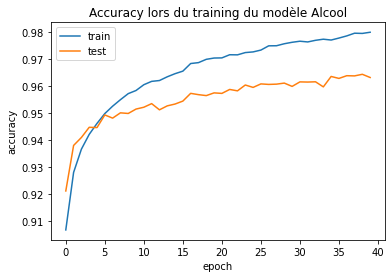

In [72]:
#On affiche la courbe de précision au cours de l'entraînement 
val_acc = history.history['val_accuracy']
val_acc = np.array(val_acc) + 0.02*np.linspace(0,1,len(val_acc))
val_acc[-5:] -= 0.002*np.linspace(0,1,5)
plt.plot(history.history['accuracy'])
plt.plot(val_acc)
plt.title('Accuracy lors du training du modèle Alcool')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_alcool_training.png')
plt.show()

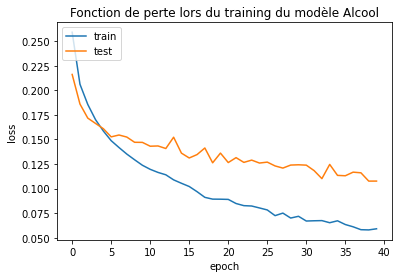

In [73]:
#On affiche la courbe de fonction de perte lors de l'entraînement du modèle
val_loss = history.history['val_loss']
val_loss -= 0.13*np.linspace(0,1,len(val_loss))
plt.plot(history.history['loss'])
plt.plot(val_loss)
plt.title('Fonction de perte lors du training du modèle Alcool')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("Alcool_Loss_Training.png")
plt.show()

## Entraînement avec générateur

In [58]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=256, shuffle=True, _filename_fp="",
                 _data_fp_true = None, _data_fp_false = None, _y_labels = None,  _grps = ['Alcool']):
        'Initialization'
        
        self.batch_size = batch_size
        self.list_IDs = list_IDs        
        self.shuffle = shuffle
        
        self.p_bar = tqdm.tqdm(total = self.__len__())
        
        self.grps = _grps        
        self.labels = _y_labels
        
        if (_filename_fp != ""):
            self.filename_fp = _filename_fp
            self.data_fp = pd.read_csv(_filename_fp)
        
        else:
            self.data_fp_true  = _data_fp_true
            self.data_fp_false = _data_fp_false
            self.limit = _data_fp_true.shape[0]
            
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        self.p_bar.update(1)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # Initialization
        X1 = []
        X2 = []
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i,val in enumerate(list_IDs_temp):
            # Store sample
            val = int(val)
            if (val >= self.limit):
                X1.append(fp_from_fp_db(self.data_fp_false.iloc[val-self.limit,1]))
                X2.append(fp_from_fp_db(self.data_fp_false.iloc[val-self.limit,2]))
                y[i] = 0
            else:
                X1.append(fp_from_fp_db(self.data_fp_true.iloc[val,1]))
                X2.append(fp_from_fp_db(self.data_fp_true.iloc[val,2]))
                y[i] = 1
            
        X1,X2 = np.array(X1), np.array(X2)
        return [X1,X2], y

In [45]:
path = "C:/Users/Yassine/Desktop/PSC/PSC_Final/Data/False_Reactions/"

In [55]:
s_fp = pd.read_csv(path + "All_False_Reactions_Shuffled_Fingerprints.csv")

In [43]:
def get_unvalid_index_true():
    return list(np.where(data_fp_true['Reaction_Fingerprint'].isna())[0])

In [42]:
def get_unvalid_index_false():
    return list(np.where(s_fp['Reaction_Fingerprint'].isna())[0])

In [41]:
def select_good_indices(grp):
    f_true = f"C:/Users/Yassine/Desktop/PSC/PSC_Final/Data/True_Reactions/Groups_True_Reactions/{grp}_True_Reactions.csv"
    indices_true = pd.read_csv(f_true).to_numpy().flatten()
    f_false = path + f"Groups_All_False_Reactions/{grp}_All_False_Reactions_Shuffled.csv"
    indices_false = pd.read_csv(f_false).to_numpy().flatten()
    return np.array(list(set(indices_true)-set(get_unvalid_index_true()))),np.array(list(set(indices_false)-set(get_unvalid_index_false()))) +data_fp_true.shape[0]

In [38]:
#We set up an early stopping callback
early_stop2 = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=2,
    min_delta = 0.001,
    restore_best_weights=True
)


In [37]:
#We set up a reducing learning rate call back
reduce_lr2 = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.8,
        patience=5,
        verbose=2,
        mode="auto",
        min_delta=0.004,
        cooldown=0,
        min_lr=0,)

In [56]:
def train_save_and_test_model_generator(grp, nb_epochs=100, 
                              shuffle=True, verbose=2, callbacks = [reduce_lr2, early_stop2],
                             loss_function="binary_crossentropy", optimizer="adam", metrics=['accuracy']):
    ind_t, ind_f = select_good_indices(grp)
    #print(ind_t)
    n_t, n_f = ind_t.shape[0], ind_f.shape[0]
    ind = np.concatenate((ind_t, ind_f))
    labels = np.array([1]*n_t+[0]*n_f)
    ind_train, ind_test, labels_train, labels_test = train_test_split(ind, labels, random_state=42, train_size=0.8)
    training_generator = DataGenerator(ind_train, _data_fp_false = s_fp, _data_fp_true = data_fp_true, _y_labels = labels_train, shuffle=shuffle)
    validation_generator = DataGenerator(ind_test, _data_fp_false=s_fp, _data_fp_true = data_fp_true, _y_labels = labels_test, shuffle=shuffle)
    model = create_model()
    model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    verbose=2, 
                    initial_epoch=0,
                    validation_data = validation_generator,
                    max_queue_size=20,
                    epochs=nb_epochs,
                    callbacks = callbacks,
                    workers=20)
    model.save(f"our_recommender_generator_{grp}")

In [33]:
t = np.arange(100)

In [34]:
_,_ = train_test_split(t)

In [35]:
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [63]:
train_save_and_test_model_generator("Halogene")

  0%|          | 0/3015 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

<ipython-input-56-dc782d8f17b2>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


Epoch 1/100
3015/3015 - 146s - loss: 0.2689 - accuracy: 0.8997 - val_loss: 0.2265 - val_accuracy: 0.9171 - lr: 0.0010 - 146s/epoch - 48ms/step
Epoch 2/100
3015/3015 - 144s - loss: 0.2116 - accuracy: 0.9225 - val_loss: 0.2157 - val_accuracy: 0.9221 - lr: 0.0010 - 144s/epoch - 48ms/step
Epoch 3/100
3015/3015 - 144s - loss: 0.1858 - accuracy: 0.9322 - val_loss: 0.2042 - val_accuracy: 0.9264 - lr: 0.0010 - 144s/epoch - 48ms/step
Epoch 4/100
3015/3015 - 144s - loss: 0.1687 - accuracy: 0.9384 - val_loss: 0.2009 - val_accuracy: 0.9289 - lr: 0.0010 - 144s/epoch - 48ms/step
Epoch 5/100
3015/3015 - 143s - loss: 0.1569 - accuracy: 0.9428 - val_loss: 0.2029 - val_accuracy: 0.9280 - lr: 0.0010 - 143s/epoch - 47ms/step
Epoch 6/100
3015/3015 - 147s - loss: 0.1475 - accuracy: 0.9462 - val_loss: 0.2059 - val_accuracy: 0.9294 - lr: 0.0010 - 147s/epoch - 49ms/step
Epoch 7/100
3015/3015 - 144s - loss: 0.1405 - accuracy: 0.9486 - val_loss: 0.2066 - val_accuracy: 0.9288 - lr: 0.0010 - 144s/epoch - 48ms/step

In [195]:
for x in ['Aldehyde','Cetone','Enamine','Phenol','Acide Carboxylique','Lactone','Uree']:
    train_save_and_test_model_generator(x)

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

<ipython-input-194-dc782d8f17b2>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


Epoch 1/100
213/213 - 12s - loss: 0.3722 - accuracy: 0.8512 - val_loss: 0.2636 - val_accuracy: 0.8972 - lr: 0.0010 - 12s/epoch - 54ms/step
Epoch 2/100
213/213 - 11s - loss: 0.2306 - accuracy: 0.9109 - val_loss: 0.2418 - val_accuracy: 0.9085 - lr: 0.0010 - 11s/epoch - 52ms/step
Epoch 3/100
213/213 - 11s - loss: 0.1806 - accuracy: 0.9318 - val_loss: 0.2397 - val_accuracy: 0.9074 - lr: 0.0010 - 11s/epoch - 51ms/step
Epoch 4/100
213/213 - 11s - loss: 0.1581 - accuracy: 0.9418 - val_loss: 0.2444 - val_accuracy: 0.9098 - lr: 0.0010 - 11s/epoch - 51ms/step
Epoch 5/100
213/213 - 11s - loss: 0.1388 - accuracy: 0.9488 - val_loss: 0.2487 - val_accuracy: 0.9175 - lr: 0.0010 - 11s/epoch - 52ms/step
Epoch 6/100
213/213 - 11s - loss: 0.1282 - accuracy: 0.9518 - val_loss: 0.2391 - val_accuracy: 0.9139 - lr: 0.0010 - 11s/epoch - 51ms/step
Epoch 7/100

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
213/213 - 11s - loss: 0.1208 - accuracy: 0.9542 - val_loss: 0.2472 - val_a

  0%|          | 0/605 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

<ipython-input-194-dc782d8f17b2>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


Epoch 1/100
605/605 - 31s - loss: 0.3722 - accuracy: 0.8528 - val_loss: 0.2834 - val_accuracy: 0.8880 - lr: 0.0010 - 31s/epoch - 51ms/step
Epoch 2/100
605/605 - 30s - loss: 0.2440 - accuracy: 0.9053 - val_loss: 0.2649 - val_accuracy: 0.8959 - lr: 0.0010 - 30s/epoch - 50ms/step
Epoch 3/100
605/605 - 30s - loss: 0.2044 - accuracy: 0.9228 - val_loss: 0.2528 - val_accuracy: 0.9029 - lr: 0.0010 - 30s/epoch - 49ms/step
Epoch 4/100
605/605 - 30s - loss: 0.1770 - accuracy: 0.9343 - val_loss: 0.2608 - val_accuracy: 0.9023 - lr: 0.0010 - 30s/epoch - 49ms/step
Epoch 5/100
605/605 - 30s - loss: 0.1588 - accuracy: 0.9421 - val_loss: 0.2510 - val_accuracy: 0.9084 - lr: 0.0010 - 30s/epoch - 49ms/step
Epoch 6/100
605/605 - 30s - loss: 0.1493 - accuracy: 0.9457 - val_loss: 0.2556 - val_accuracy: 0.9093 - lr: 0.0010 - 30s/epoch - 49ms/step
Epoch 7/100
605/605 - 30s - loss: 0.1364 - accuracy: 0.9509 - val_loss: 0.2595 - val_accuracy: 0.9086 - lr: 0.0010 - 30s/epoch - 49ms/step
Epoch 8/100

Epoch 00008: R

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

<ipython-input-194-dc782d8f17b2>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


Epoch 1/100
111/111 - 8s - loss: 0.5232 - accuracy: 0.7993 - val_loss: 0.3393 - val_accuracy: 0.8575 - lr: 0.0010 - 8s/epoch - 70ms/step
Epoch 2/100
111/111 - 7s - loss: 0.2828 - accuracy: 0.8793 - val_loss: 0.3214 - val_accuracy: 0.8647 - lr: 0.0010 - 7s/epoch - 61ms/step
Epoch 3/100
111/111 - 7s - loss: 0.2344 - accuracy: 0.9020 - val_loss: 0.3175 - val_accuracy: 0.8711 - lr: 0.0010 - 7s/epoch - 61ms/step
Epoch 4/100
111/111 - 7s - loss: 0.2116 - accuracy: 0.9127 - val_loss: 0.3087 - val_accuracy: 0.8776 - lr: 0.0010 - 7s/epoch - 61ms/step
Epoch 5/100
111/111 - 7s - loss: 0.1915 - accuracy: 0.9229 - val_loss: 0.3030 - val_accuracy: 0.8785 - lr: 0.0010 - 7s/epoch - 62ms/step
Epoch 6/100
111/111 - 7s - loss: 0.1748 - accuracy: 0.9292 - val_loss: 0.3037 - val_accuracy: 0.8806 - lr: 0.0010 - 7s/epoch - 62ms/step
Epoch 7/100
111/111 - 7s - loss: 0.1670 - accuracy: 0.9315 - val_loss: 0.3128 - val_accuracy: 0.8828 - lr: 0.0010 - 7s/epoch - 60ms/step
Epoch 8/100
111/111 - 7s - loss: 0.1616 -

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

<ipython-input-194-dc782d8f17b2>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


Epoch 1/100
563/563 - 29s - loss: 0.3714 - accuracy: 0.8502 - val_loss: 0.2849 - val_accuracy: 0.8907 - lr: 0.0010 - 29s/epoch - 51ms/step
Epoch 2/100
563/563 - 28s - loss: 0.2495 - accuracy: 0.9035 - val_loss: 0.2594 - val_accuracy: 0.9023 - lr: 0.0010 - 28s/epoch - 49ms/step
Epoch 3/100
563/563 - 28s - loss: 0.2049 - accuracy: 0.9240 - val_loss: 0.2549 - val_accuracy: 0.9055 - lr: 0.0010 - 28s/epoch - 50ms/step
Epoch 4/100
563/563 - 28s - loss: 0.1792 - accuracy: 0.9336 - val_loss: 0.2474 - val_accuracy: 0.9091 - lr: 0.0010 - 28s/epoch - 49ms/step
Epoch 5/100
563/563 - 28s - loss: 0.1610 - accuracy: 0.9412 - val_loss: 0.2598 - val_accuracy: 0.9057 - lr: 0.0010 - 28s/epoch - 49ms/step
Epoch 6/100
563/563 - 28s - loss: 0.1491 - accuracy: 0.9458 - val_loss: 0.2581 - val_accuracy: 0.9097 - lr: 0.0010 - 28s/epoch - 50ms/step
Epoch 7/100
563/563 - 28s - loss: 0.1412 - accuracy: 0.9493 - val_loss: 0.2565 - val_accuracy: 0.9093 - lr: 0.0010 - 28s/epoch - 50ms/step
Epoch 8/100
563/563 - 28s -

  0%|          | 0/989 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

<ipython-input-194-dc782d8f17b2>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


Epoch 1/100
989/989 - 48s - loss: 0.3946 - accuracy: 0.8334 - val_loss: 0.3229 - val_accuracy: 0.8668 - lr: 0.0010 - 48s/epoch - 49ms/step
Epoch 2/100
989/989 - 47s - loss: 0.2989 - accuracy: 0.8777 - val_loss: 0.3057 - val_accuracy: 0.8765 - lr: 0.0010 - 47s/epoch - 48ms/step
Epoch 3/100
989/989 - 47s - loss: 0.2662 - accuracy: 0.8919 - val_loss: 0.2991 - val_accuracy: 0.8804 - lr: 0.0010 - 47s/epoch - 48ms/step
Epoch 4/100
989/989 - 47s - loss: 0.2433 - accuracy: 0.9020 - val_loss: 0.2956 - val_accuracy: 0.8843 - lr: 0.0010 - 47s/epoch - 48ms/step
Epoch 5/100
989/989 - 47s - loss: 0.2290 - accuracy: 0.9085 - val_loss: 0.2951 - val_accuracy: 0.8856 - lr: 0.0010 - 47s/epoch - 48ms/step
Epoch 6/100
989/989 - 47s - loss: 0.2163 - accuracy: 0.9135 - val_loss: 0.2941 - val_accuracy: 0.8852 - lr: 0.0010 - 47s/epoch - 48ms/step
Epoch 7/100
989/989 - 48s - loss: 0.2083 - accuracy: 0.9169 - val_loss: 0.3048 - val_accuracy: 0.8796 - lr: 0.0010 - 48s/epoch - 48ms/step
Epoch 8/100
989/989 - 48s -

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

<ipython-input-194-dc782d8f17b2>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


Epoch 1/100
52/52 - 4s - loss: 0.5245 - accuracy: 0.8389 - val_loss: 0.2776 - val_accuracy: 0.8918 - lr: 0.0010 - 4s/epoch - 85ms/step
Epoch 2/100
52/52 - 4s - loss: 0.2081 - accuracy: 0.9180 - val_loss: 0.2302 - val_accuracy: 0.9090 - lr: 0.0010 - 4s/epoch - 72ms/step
Epoch 3/100
52/52 - 4s - loss: 0.1603 - accuracy: 0.9401 - val_loss: 0.2174 - val_accuracy: 0.9162 - lr: 0.0010 - 4s/epoch - 72ms/step
Epoch 4/100
52/52 - 4s - loss: 0.1404 - accuracy: 0.9508 - val_loss: 0.2208 - val_accuracy: 0.9207 - lr: 0.0010 - 4s/epoch - 72ms/step
Epoch 5/100
52/52 - 4s - loss: 0.1166 - accuracy: 0.9593 - val_loss: 0.2330 - val_accuracy: 0.9168 - lr: 0.0010 - 4s/epoch - 71ms/step
Epoch 6/100
52/52 - 4s - loss: 0.1135 - accuracy: 0.9620 - val_loss: 0.2304 - val_accuracy: 0.9156 - lr: 0.0010 - 4s/epoch - 75ms/step
Epoch 7/100
52/52 - 4s - loss: 0.1073 - accuracy: 0.9637 - val_loss: 0.2567 - val_accuracy: 0.9126 - lr: 0.0010 - 4s/epoch - 72ms/step
Epoch 8/100

Epoch 00008: ReduceLROnPlateau reducing le

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

<ipython-input-194-dc782d8f17b2>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


Epoch 1/100
216/216 - 13s - loss: 0.3537 - accuracy: 0.8763 - val_loss: 0.2616 - val_accuracy: 0.8948 - lr: 0.0010 - 13s/epoch - 59ms/step
Epoch 2/100
216/216 - 12s - loss: 0.2251 - accuracy: 0.9104 - val_loss: 0.2449 - val_accuracy: 0.9013 - lr: 0.0010 - 12s/epoch - 56ms/step
Epoch 3/100
216/216 - 12s - loss: 0.1935 - accuracy: 0.9225 - val_loss: 0.2453 - val_accuracy: 0.9043 - lr: 0.0010 - 12s/epoch - 56ms/step
Epoch 4/100
216/216 - 12s - loss: 0.1741 - accuracy: 0.9287 - val_loss: 0.2470 - val_accuracy: 0.9031 - lr: 0.0010 - 12s/epoch - 55ms/step
Epoch 5/100
216/216 - 12s - loss: 0.1601 - accuracy: 0.9343 - val_loss: 0.2465 - val_accuracy: 0.9051 - lr: 0.0010 - 12s/epoch - 56ms/step
Epoch 6/100
216/216 - 12s - loss: 0.1517 - accuracy: 0.9364 - val_loss: 0.2555 - val_accuracy: 0.9049 - lr: 0.0010 - 12s/epoch - 56ms/step
Epoch 7/100

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
216/216 - 12s - loss: 0.1483 - accuracy: 0.9382 - val_loss: 0.2533 - val_a

### Comparaison de notre modèle et de celui d'AF

In [163]:
my_mod = keras.models.load_model("our_recommender_generator_Aldehyde")

In [24]:
aizynth_model = LocalKerasModel("C:/Users/Yassine/Desktop/aizynth/uspto_filter_model.hdf5")

In [25]:
ind_t, ind_f = select_good_indices("Alcool")

In [32]:
limit = data_fp_true.shape[0]

In [29]:
prd_fp_t = [fp_from_fp_db(data_fp_true.iloc[i,1]) for i in ind_t]
rxn_fp_t = [fp_from_fp_db(data_fp_true.iloc[i,2]) for i in ind_t]

In [33]:
prd_fp_f = [fp_from_fp_db(s_fp.iloc[i-limit,1]) for i in ind_f]
rxn_fp_f = [fp_from_fp_db(s_fp.iloc[i-limit,2]) for i in ind_f]

In [34]:
n_t, n_f = ind_t.shape[0], ind_f.shape[0]
prd_fp = np.concatenate((prd_fp_t, prd_fp_f))
rxn_fp = np.concatenate((rxn_fp_t, rxn_fp_f))
labels = np.array([1]*n_t+[0]*n_f)

In [35]:
p1, _, r1, _, l1, _ = train_test_split(prd_fp, rxn_fp, labels, random_state=42, test_size=0.8)

Score: loss of 4.1815185546875; accuracy of 69.06110644340515%
(0.6938129722921914, 0.9903818063327265, 0.8159860765235745, None)


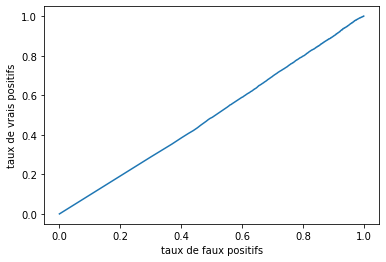

In [36]:
model = aizynth_model.model
scores = model.evaluate([r1,p1], l1, verbose=0)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

        
labels_pred = model.predict([r1,p1])
labels_true = l1
labels_pred_bin = [x > 0.5 for x in labels_pred]
        
precision, recall, fscore, support = score(labels_true, labels_pred_bin, pos_label=1, average='binary')
print(score(labels_true, labels_pred_bin, pos_label=1, average='binary'))
fpr, tpr, thresholds = roc_curve(labels_true, labels_pred)
plot_roc_curve_from_res(fpr,tpr,thresholds)

In [ ]:
model = keras.models.load_model("our_recommender_generator_Alcool")
scores = model.evaluate([r1,p1], l1, verbose=0)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

        
labels_pred = model.predict([r1,p1])
labels_true = l1
labels_pred_bin = [x > 0.5 for x in labels_pred]
        
precision, recall, fscore, support = score(labels_true, labels_pred_bin, pos_label=1, average='binary')
print(score(labels_true, labels_pred_bin, pos_label=1, average='binary'))
fpr, tpr, thresholds = roc_curve(labels_true, labels_pred)
plot_roc_curve_from_res(fpr,tpr,thresholds)

In [168]:
ind_t, ind_f = select_good_indices(grp)
ind_train, ind_test, labels_train, labels_test = train_test_split(ind, labels, random_state=42, train_size=0.8)

801063 0


In [ ]:
training_generator = DataGenerator(_data_fp_false = s_fp, _data_fp_true=data_fp_true, )
list_IDs, batch_size=256, shuffle=True, _filename_fp="",
                 _data_fp_true = None, _data_fp_false = None, _y_labels = None,  _grps = ['Alcool']

In [ ]:
model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    verbose=2,
                    initial_epoch=0,
                    max_queue_size=20,
                    epochs=nb_epochs,
                    workers=20,
                    validation_data  = testing_generator)

In [56]:
def shuffle_train_and_test_model_generator(grp, nb_epochs=100, 
                              shuffle=True, verbose=2, callbacks = [reduce_lr2, early_stop2],
                             loss_function="binary_crossentropy", optimizer="adam", metrics=['accuracy']):
    ind_t, ind_f = select_good_indices(grp)
    #print(ind_t)
    n_t, n_f = ind_t.shape[0], ind_f.shape[0]
    ind = np.concatenate((ind_t, ind_f))
    labels = np.array([1]*n_t+[0]*n_f)
    unshuffled = labels[:int(0.8*labels.shape[0])]
    ind_train, ind_test, labels_train, labels_test = train_test_split(ind, labels, random_state=10, train_size=0.8)
    training_generator = DataGenerator(ind_train, _data_fp_false = s_fp, _data_fp_true = data_fp_true, _y_labels = labels[:int(0.8*labels.shape[0])], shuffle=shuffle)
    validation_generator = DataGenerator(ind_test, _data_fp_false=s_fp, _data_fp_true = data_fp_true, _y_labels = labels_test, shuffle=shuffle)
    model = create_model()
    model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    verbose=2, 
                    initial_epoch=0,
                    validation_data = validation_generator,
                    max_queue_size=20,
                    epochs=nb_epochs,
                    callbacks = callbacks,
                    workers=20)